In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')

plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})

from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression, Lasso
import warnings 
import statsmodels.api as sm

ROOT_PATH = 'data/'
freq = 'MS' #'QS'
NUM_LAGS = 13

# ETL 

In [3]:
def extract_data_from_StatsCanada(file_name, in_col, out_cols, new_names=None, filters = None):
    df = pd.read_csv(f'{ROOT_PATH}{file_name}')
    df['Date'] = pd.to_datetime(['-'.join(x.split()[::-1]) for x in df['REF_DATE']])
    df.sort_values(by='Date', inplace=True)
    
    df_res = pd.DataFrame(index=df['Date'].drop_duplicates())

    for col in out_cols:
        if in_col:
            df_ = df[df[in_col] == col]
        else: 
            df_ = df
        if filters:
            for filter, value in filters.items():
                df_ = df_[df_[filter] == value]
        df_ = df_[["VALUE", "Date"]].set_index("Date")

        df_res = pd.concat([df_res, df_], axis = 1)
    df_res.columns = new_names if new_names else out_cols
    return df_res

def extract_data_from_CREA(file_name, sheet_name, in_col, new_names=None):
    df_v = pd.read_excel(f'{ROOT_PATH}{file_name}',sheet_name=sheet_name)
    df_v['Date'] = pd.to_datetime(df_v['Date'], format='%b %y')
    df_v.set_index('Date',inplace=True)

    df_v = pd.DataFrame(df_v[in_col]).dropna()
    df_v.columns = new_names if new_names else in_col
    return df_v

def make_lags(df, num_lags, lagged_cols = None):
    df = pd.DataFrame(df)
    if not lagged_cols:
        lagged_cols = df.columns
    for col in lagged_cols:
        for lag in range(1,num_lags):
            df[f"{col}_lag_{lag}"] = df[col].shift(lag)

    return df

def transform(df, transform_dict):
    for col, funcs in transform_dict.items():
        if isinstance(funcs, list):
            for func in funcs:
                df[f"{col}_{func.__name__}"] = pd.DataFrame(df[col]).apply(func)
        else:
            df[f"{col}_{funcs.__name__}"] = pd.DataFrame(df[col]).apply(funcs)
    return df

# ETL pipeline
def etl_pipeline(extraction_function, transform_dict=None, freq=freq, num_lags = NUM_LAGS, lagged_cols = None,  **kwargs):
    # Extract
    extracted_df = extraction_function(**kwargs)
    
    # Transform
    transformed_df = extracted_df.sort_index().resample(freq).first()
    # print(transformed_df)
    if transform_dict:
        transformed_df = transform(transformed_df, transform_dict)
    transformed_df = make_lags(transformed_df, num_lags, lagged_cols)
    
    return transformed_df

def growth(x):
    def inner(series):
        return np.log(series).diff(x)
    inner.__name__ = f"growth{x}"
    return inner

def diff(x):
    def inner(series):
        return series.diff(x)
    inner.__name__ = f"diff{x}"
    return inner

def infl_adjusted(infl):
    def inner(series):
        df_ = pd.concat([series, infl], axis = 1)
        return (df_.iloc[:,0] * df_.iloc[-1,1]/df_.iloc[:,1])
    inner.__name__ = f"real"
    return inner

def rolling_mean(x):
    def inner(series):
        return series.rolling(x).mean()
    inner.__name__ = f"mean{x}"
    return inner

def compose(f, g):
    def inner(x):
        return f(g(x))
    inner.__name__ = f"{f.__name__}_{g.__name__}"
    return inner

## Target series analysis

Index(['HPI', 'HPI_real', 'HPI_growth1_real', 'HPI_growth1_real_lag_1',
       'HPI_growth1_real_lag_2', 'HPI_growth1_real_lag_3',
       'HPI_growth1_real_lag_4', 'HPI_growth1_real_lag_5',
       'HPI_growth1_real_lag_6'],
      dtype='object')


<AxesSubplot:xlabel='Date'>

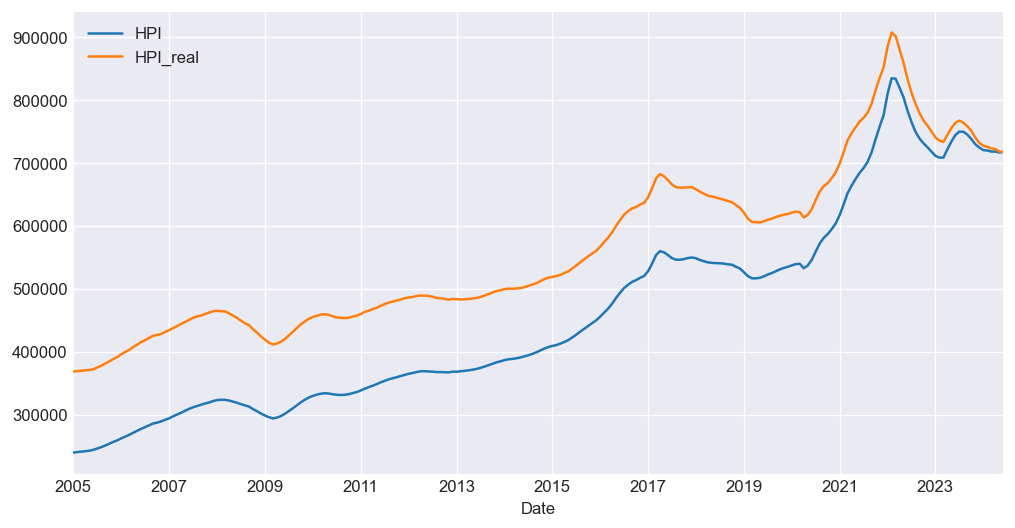

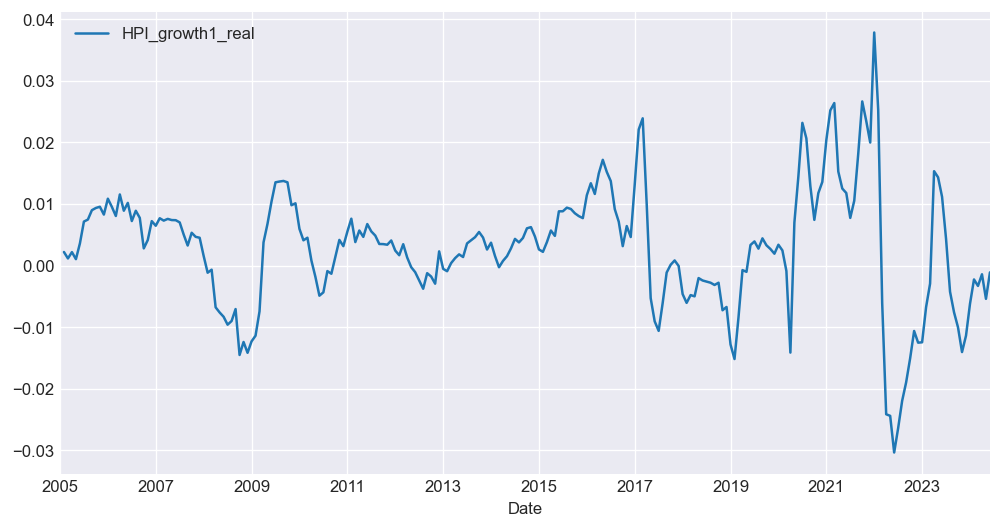

In [4]:
cpi = etl_pipeline(extract_data_from_StatsCanada, file_name = '1810025601_databaseLoadingData.csv', 
                    in_col = "Alternative measures",
                    out_cols = ["Measure of core inflation based on a weighted median approach, CPI-median (index, 198901=100)"],
                    new_names = ['CPI'],
                    num_lags = 1)

df = etl_pipeline(extract_data_from_CREA, file_name = 'MLS_HPI/Seasonally Adjusted_June_2024.xlsx', sheet_name = 'AGGREGATE',
                in_col = "Composite_Benchmark_SA", new_names = ["HPI"],
                num_lags = 7, lagged_cols = ['HPI_growth1_real'],
                transform_dict = {"HPI": [infl_adjusted(cpi), compose(growth(1), infl_adjusted(cpi))]})


print(df.columns)

target = "HPI_growth1_real" 
# df = df[target].dropna()
# df.plot()
df[['HPI','HPI_real']].plot()
plt.figure()
df[target].plot(legend="top")

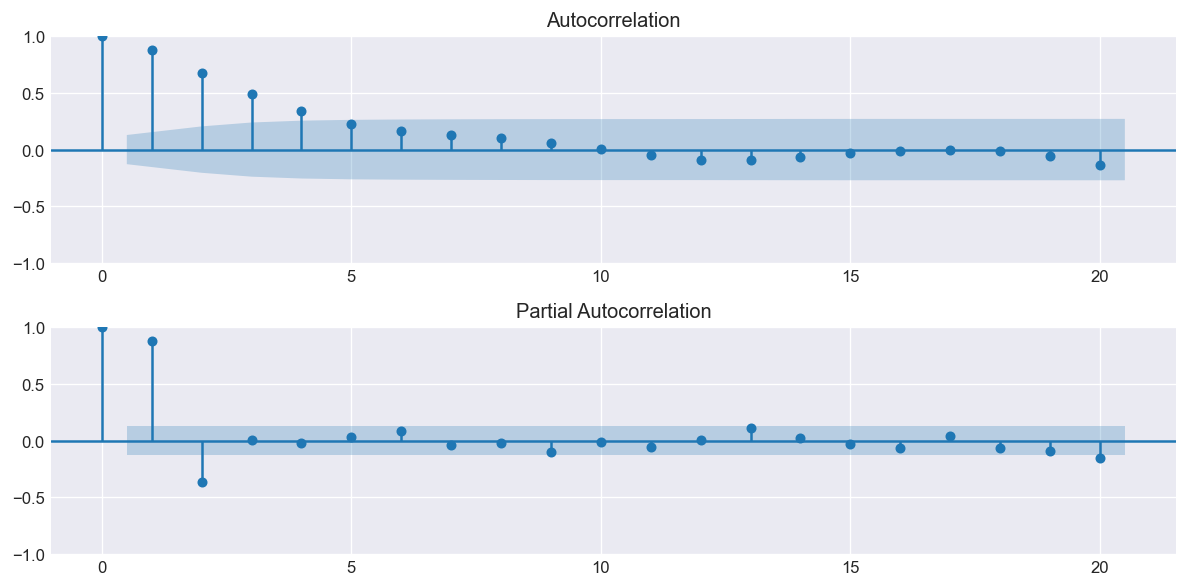

In [5]:
f, ax = plt.subplots(nrows=2, ncols=1)
plot_acf(df[target].dropna(),lags=20, ax=ax[0])
plot_pacf(df[target].dropna(),lags=20, ax=ax[1])
plt.tight_layout()
plt.show()

In [13]:
# df = pd.read_excel(f'{ROOT_PATH}RPS_HPI_PublicRelease_202406.xlsx',sheet_name="202406_V3",header=1, nrows= 234)

## Covariates engineering

In [6]:

df_cov = df.join(etl_pipeline(extract_data_from_StatsCanada, file_name = '1410028701_databaseLoadingData.csv',
                            in_col = "Labour force characteristics", 
                            out_cols = ["Participation rate", "Employment rate", "Unemployment rate","Population", "Labour force",]
                            ))

df_cov = df_cov.join(etl_pipeline(extract_data_from_StatsCanada, file_name = '3410014501_databaseLoadingData.csv', in_col = None, out_cols = ["Mortgage rate 5y"],
                         transform_dict = {"Mortgage rate 5y": [diff(1), diff(12), growth(1), growth(12),rolling_mean(3),compose(growth(12),rolling_mean(3)),
                                                                compose(growth(1),rolling_mean(3))]
                                          }))

df_cov = df_cov.join(etl_pipeline(extract_data_from_StatsCanada, file_name = '1810020501_databaseLoadingData.csv', 
                                     in_col = "New housing price indexes",
                                     out_cols = ["Total (house and land)"],
                                     new_names = ["NHPI"],
                                     transform_dict = {"NHPI": compose(growth(1), infl_adjusted(cpi)) }))


df_cov = df_cov.join(etl_pipeline(extract_data_from_StatsCanada, file_name = '1010011601_databaseLoadingData.csv', 
                                     in_col = "Assets, liabilities and monetary aggregates",
                                     out_cols = ["M2 (gross) (currency outside banks, chartered bank demand and notice deposits, chartered bank personal term deposits, adjustments to M2 (gross) (continuity adjustments and inter-bank demand and notice deposits))",
                                      "M2++ (gross) (M2+ (gross), Canada Savings Bonds, non-money market mutual funds)"],
                                     new_names = ["M2", "M2++"],
                                     transform_dict = {"M2": [infl_adjusted(cpi), compose(growth(1), infl_adjusted(cpi)),compose(growth(12), infl_adjusted(cpi))],
                                                       "M2++": [compose(growth(12), infl_adjusted(cpi)),
                                                                compose(growth(1), infl_adjusted(cpi)), 
                                                                ]}))
# df_cov = df_cov.join(etl_pipeline(extract_data_from_StatsCanada, file_name = '3410013501_databaseLoadingData.csv', 
#                                      in_col = "Housing estimates",
#                                      out_cols = ["Housing starts","Housing under construction", "Housing completions" ],
#                                      filters = {"Type of unit": "Total units"},
#                                      transform_dict = {"Housing completions": growth(4),
#                                                        "Housing starts": growth(4),
#                                                        "Housing under construction": growth(4)}))

# df_cov = df_cov.join(etl_pipeline(extract_data_from_StatsCanada, file_name = '3610011201_databaseLoadingData.csv', 
#                                     in_col = "Estimates",
#                                     out_cols = ["Equals: household disposable income","Compensation of employees", "Household saving rate"],
#                                     new_names = ["Disposable income","Compensation", "Household saving rate"],
#                                     transform_dict = {"Disposable income": compose(growth(1), infl_adjusted(cpi)),
#                                                       "Compensation": compose(growth(1), infl_adjusted(cpi)),
#                                                       "Household saving rate": rolling_mean(3)}))

# df_cov = df_cov.join(etl_pipeline(extract_data_from_StatsCanada, file_name = '3610049101_databaseLoadingData.csv', 
#                                       in_col = "North American Industry Classification System (NAICS)",
#                                       out_cols = ["All industries [T001]"], 
#                                       new_names = ["GDP"],
#                                       filters = {"Release": "May 31, 2024"},
#                                       transform_dict = {"GDP": growth(12)}))

df_cov = df_cov.join(etl_pipeline(extract_data_from_CREA, file_name = 'News_release_chart_data_May_2024.xlsx', sheet_name="Chart A",
                      in_col = ["Canada"],
                      new_names = ["Sales"],))

df_cov = df_cov.ffill().bfill()
df_cov = df_cov[sorted(df_cov.columns)]

# df_cov

corr_lag = df_cov.corr()[target][df_cov.corr()[target].abs()>0.3].sort_values()
df_cov.corr()

/var/folders/yv/s556grcd04xf99g1bgg7tych0000gn/T/ipykernel_52944/3255800627.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_{lag}"] = df[col].shift(lag)
/var/folders/yv/s556grcd04xf99g1bgg7tych0000gn/T/ipykernel_52944/3255800627.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_{lag}"] = df[col].shift(lag)
/var/folders/yv/s556grcd04xf99g1bgg7tych0000gn/T/ipykernel_52944/3255800627.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Employment rate  Employment rate_lag_1  \
Employment rate                 1.000000               0.903674   
Employment rate_lag_1           0.903674               1.000000   
Employment rate_lag_10          0.388130               0.428026   
Employment rate_lag_11          0.356258               0.390074   
Employment rate_lag_12          0.345211               0.358694   
...                                  ...                    ...   
Unemployment rate_lag_5        -0.236745              -0.288431   
Unemployment rate_lag_6        -0.199334              -0.238489   
Unemployment rate_lag_7        -0.172753              -0.200436   
Unemployment rate_lag_8        -0.155631              -0.174778   
Unemployment rate_lag_9        -0.129207              -0.157552   

                         Employment rate_lag_10  Employment rate_lag_11  \
Employment rate                        0.388130                0.356258   
Employment rate_lag_1                  0.428026                0.390074   
Employment rate_lag_10                 1.000000                0.906403   
Employment rate_lag_11                 0.906403                1.000000   
Employment rate_lag_12                 0.758298                0.906779   
...                                         ...                     ...   
Unemployment rate_lag_5               -0.287528               -0.241067   
Unemployment rate_lag_6               -0.337624               -0.288396   
Unemployment rate_lag_7               -0.410179               -0.337628   
Unemployment rate_lag_8               -0.516126               -0.411285   
Unemployment rate_lag_9               -0.644433               -0.517187   

                         Employment rate_lag_12  Employment rate_lag_2  \
Employment rate                        0.345211               0.750999   
Employment rate_lag_1                  0.358694               0.903966   
Employment rate_lag_10                 0.758298               0.451660   
Employment rate_lag_11                 0.906779               0.429740   
Employment rate_lag_12                 1.000000               0.392201   
...                                         ...                    ...   
Unemployment rate_lag_5               -0.197074              -0.355987   
Unemployment rate_lag_6               -0.240280              -0.289435   
Unemployment rate_lag_7               -0.286693              -0.238819   
Unemployment rate_lag_8               -0.336901              -0.201662   
Unemployment rate_lag_9               -0.410347              -0.175833   

                         Employment rate_lag_3  Employment rate_lag_4  \
Employment rate                       0.648103               0.579809   
Employment rate_lag_1                 0.751665               0.649041   
Employment rate_lag_10                0.470345               0.498091   
Employment rate_lag_11                0.453387               0.471728   
Employment rate_lag_12                0.431822               0.455032   
...                                        ...                    ...   
Unemployment rate_lag_5              -0.452256              -0.593475   
Unemployment rate_lag_6              -0.357429              -0.453071   
Unemployment rate_lag_7              -0.290248              -0.357685   
Unemployment rate_lag_8              -0.240533              -0.291236   
Unemployment rate_lag_9              -0.203252              -0.241360   

                         Employment rate_lag_5  Employment rate_lag_6  ...  \
Employment rate                       0.529721               0.491513  ...   
Employment rate_lag_1                 0.580990               0.531134  ...   
Employment rate_lag_10                0.537045               0.587403  ...   
Employment rate_lag_11                0.499661               0.538504  ...   
Employment rate_lag_12                0.473542               0.501258  ...   
...                                        ...                    ...  ...   
Unemplo

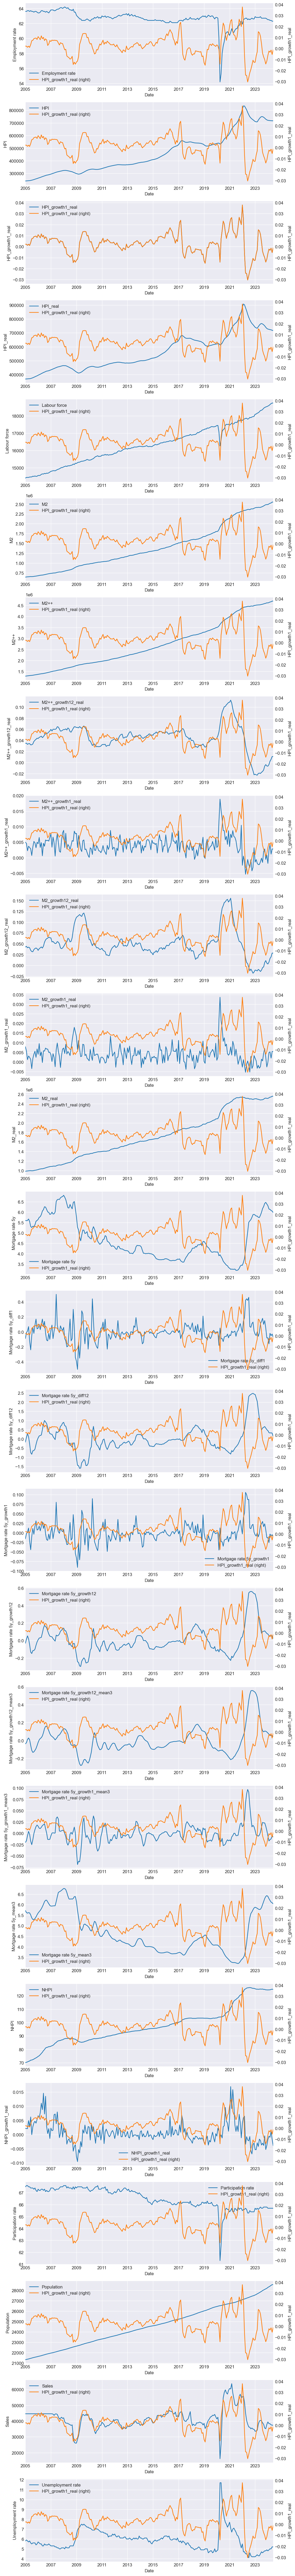

In [7]:
def plot_covariates(df, target, features = None):
    if not features:
        features = [col for col in df.columns if "lag" not in col]
    n_rows = len(features)
    fig, ax = plt.subplots(n_rows, 1, figsize=(10, 4*n_rows))
    for i,feature in enumerate(features):
        df[feature].plot(ylabel=feature, ax=ax[i], legend="left")
        df[target].plot(secondary_y=True, ylabel=target, ax=ax[i], legend="left")
plot_covariates(df_cov, target)
# plot_covariates(df_cov, target, ["Mortgage rate 5y_growth12", "M2++_growth12_real"])

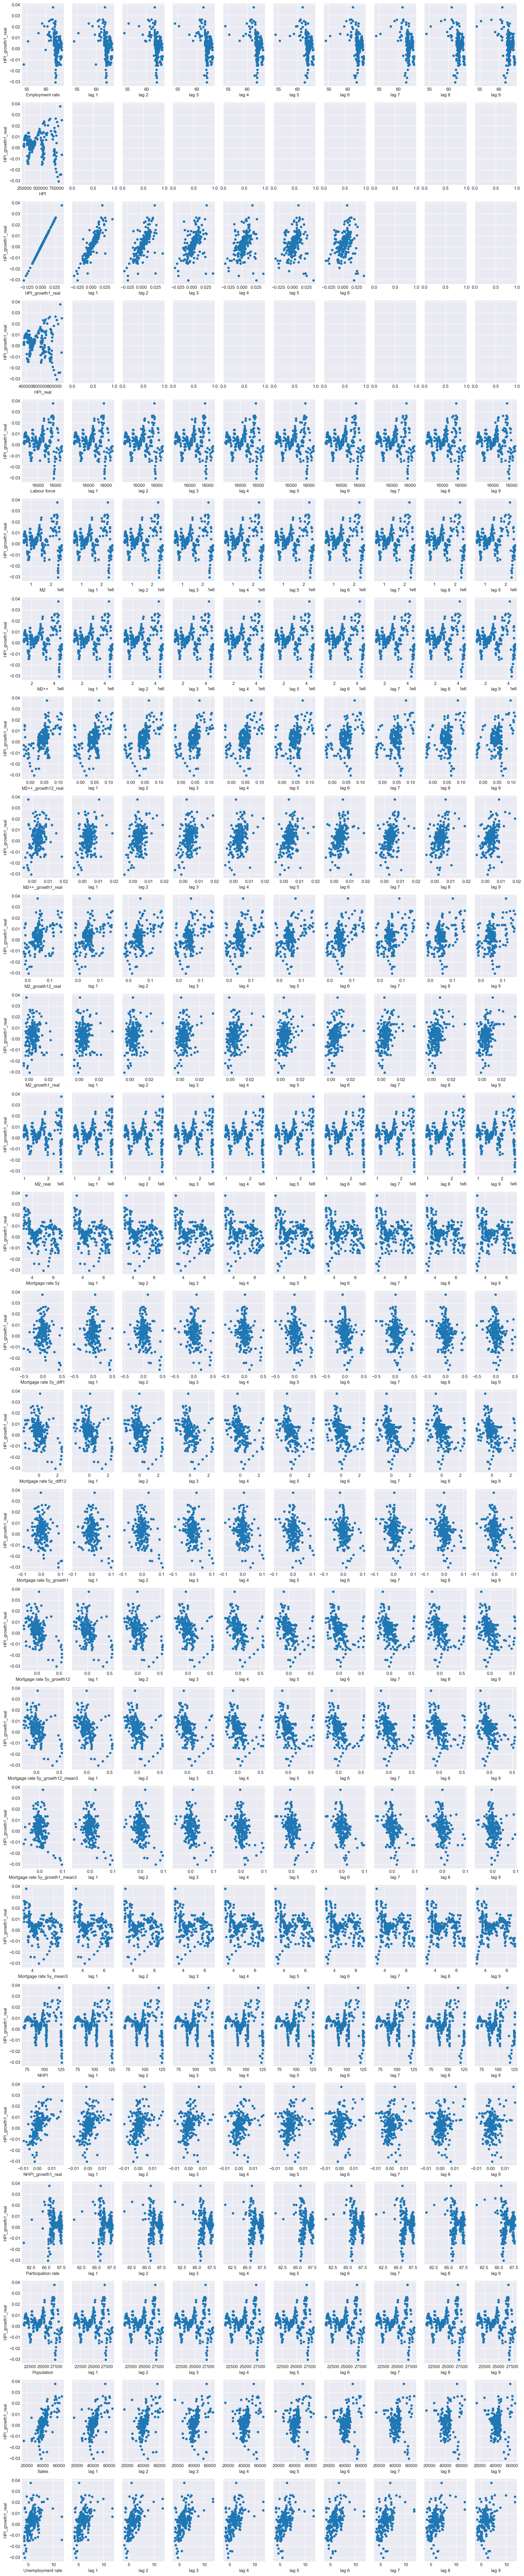

In [9]:
def plot_target_covariates(df, num_lags, target, features = None):
    if not features:
        features = [col for col in df.columns if "lag" not in col]
    n_rows = len(features)
    fig, ax = plt.subplots(n_rows, num_lags, sharey="row", figsize=(20,4*n_rows))
    for i, feature in enumerate(features):
        for j in range(num_lags):
            col_name  = feature if j==0 else feature + "_lag_" + str(j)
            if col_name in df.columns:
                df.plot.scatter(col_name, target, ax=ax[i][j])
                ax[i][j].set_xlabel(feature if j==0 else "lag " + str(j))
    
plot_target_covariates(df_cov, 10, target)
# plot_target_covariates(df_cov,7,target, ["Mortgage rate 5y_growth12", "M2++_growth1_real"])

In [109]:
pd.set_option('display.max_rows', None)
# print(corr_lag)
print(df_cov.corr()["Mortgage rate 5y_growth12"][df_cov.corr()["Mortgage rate 5y_growth12"].abs()>0.3].sort_values())
pd.reset_option('display.max_rows')

M2_growth12_real                        -0.688110
M2_growth12_real_lag_1                  -0.686350
M2_growth12_real_lag_2                  -0.674030
M2_growth12_real_lag_3                  -0.648482
M2++_growth12_real                      -0.647607
Unemployment rate                       -0.633756
Unemployment rate_lag_1                 -0.624637
M2++_growth12_real_lag_1                -0.616835
Unemployment rate_lag_2                 -0.608896
M2_growth12_real_lag_4                  -0.608538
Unemployment rate_lag_3                 -0.585616
M2++_growth12_real_lag_2                -0.576833
Unemployment rate_lag_4                 -0.556392
M2_growth12_real_lag_5                  -0.555837
M2++_growth12_real_lag_3                -0.527545
M2++_growth1_real_lag_4                 -0.524261
M2++_growth1_real_lag_3                 -0.524054
Unemployment rate_lag_5                 -0.522440
M2++_growth1_real_lag_5                 -0.519747
M2++_growth1_real_lag_2                 -0.507661


## Forecasting and Backtesting Framework

In [37]:
def mase(y_test, y_pred, y_train, sp=1):
    """Mean absolute scaled error.

    This scale-free error metric can be used to compare forecast methods on
    a single
    series and also to compare forecast accuracy between series. This metric
    is well
    suited to intermittent-demand series because it never gives infinite or
    undefined
    values.

    Parameters
    ----------
    y_test : pandas Series of shape = (fh,) where fh is the forecasting horizon
        Ground truth (correct) target values.
    y_pred : pandas Series of shape = (fh,)
        Estimated target values.
    y_train : pandas Series of shape = (n_obs,)
        Observed training values.
    sp : int
        Seasonal periodicity of training data.

    Returns
    -------
    loss : float
        MASE loss

    References
    ----------
    ..[1]   Hyndman, R. J. (2006). "Another look at measures of forecast
            accuracy", Foresight, Issue 4.
    """

    #  naive seasonal prediction
    y_train = np.asarray(y_train)
    y_pred_naive = y_train[:-sp]

    # mean absolute error of naive seasonal prediction
    mae_naive = np.mean(np.abs(y_train[sp:] - y_pred_naive))

    # if training data is flat, mae may be zero,
    # return np.nan to avoid divide by zero error
    # and np.inf values
    if mae_naive == 0:
        return np.nan
    else:
        return np.mean(np.abs(y_test - y_pred)) / mae_naive
    
class MovingAverage():
    def __init__(self, y_lags) -> None:
        self.y_lags = y_lags
    def fit(self, X, y) -> None:
        pass
    def predict(self, y):
        # print(y[0][:self.y_lags] )
        return [np.mean(y[0][:self.y_lags])]

MA = MovingAverage(1)

def hist_forecast(df, target, features, split_time, horizon, y_lags, model, retrain=True):
    features =  [target + "_lag_" + str(j) for j in range(y_lags, 0,-1) if target + "_lag_" + str(j) not in features]  + features

    val_df = df[features][split_time:]
    train_y = df[target][:split_time] 
    train_df = df[features][:split_time]

    if retrain:
        model.fit(train_df,train_y) 
        
    forecast = [train_y.iloc[-i] for i in range(y_lags, 0,-1)]
    # print(forecast)
    # print(val_df)
    for i in range(horizon):
        X = np.array(forecast[-y_lags:] + list(val_df[features[y_lags:]].iloc[i])).reshape(1, -1)
        #  print(X)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            y_pred = model.predict(X)[0]
        forecast.append(y_pred)

    forecast = forecast[y_lags:]
    return forecast

def backtesting(df, target, features, test_split_time, horizon, y_lags, model, retrain):

    pred_times = [t for i, t in enumerate(pd.date_range(start=test_split_time, end=df.index[-1], freq=df.index.inferred_freq).to_list()) if i % horizon == 0] #[t for i, t in enumerate(df[test_split_time:].index) if i % horizon == 0]
    forecast = []
    for t in pred_times:
        forecast_i = hist_forecast(df, target, features, t, horizon, y_lags, model, retrain)
        forecast.append(forecast_i)

    forecast = [e for lists in forecast for e in lists]
    return forecast

def inv_growth(dy, y0):
    return np.exp(np.cumsum(dy))*y0

def calc_metrics(y, y_hat, y_train, interval_name):
    print(interval_name+" RMSE:", mean_squared_error(y, y_hat, squared=False))
    # print(interval_name+" MAPE:", mean_absolute_percentage_error(y, y_hat))
    print(interval_name+" R^2:", r2_score(y, y_hat))
    print(interval_name+" MASE:", mase(y, y_hat, y_train, sp=1)) 

def show_results(series_args, y, preds, test_split_time, inverse_transform = False):
    y_train, y_test = y[:test_split_time], y[test_split_time:]

    if inverse_transform:
        preds = inv_growth(preds, y_train.iloc[0])
        # y_train = y_train[1:]
    
    preds = pd.Series(preds, name="Predictions", index = y.index)
    figure = plt.figure()
    preds.plot(legend="top")
    calc_metrics(y_train, preds[:test_split_time], y_train, "Train")
    calc_metrics(y_test, preds[test_split_time:], y_train, "Test")

    for args in series_args:
        series = pd.Series(args[0], name=args[1], index = y_test.index)
        if inverse_transform:
            series = inv_growth(series, y_train.iloc[-1])  
        series.plot(legend="top")

        calc_metrics(y_test, series,  y_train, args[1])
    
    y.plot(legend="top")


## Linear Regression

coefficients:  -0.00046682485762626754 [-0.23275527  1.03799483 -0.00431526  0.2529865 ]
Train RMSE: 0.0032772627734804333
Train R^2: 0.7659880653833305
Train MASE: 0.9472621019953068
Test RMSE: 0.007210007892554743
Test R^2: 0.810691808471512
Test MASE: 2.1506134740375393
Backtesting RMSE: 0.01556023177581849
Backtesting R^2: 0.11828130378832435
Backtesting MASE: 4.351250105818225
Benchmark RMSE: 0.020423459992380887
Benchmark R^2: -0.5189957695242653
Benchmark MASE: 5.8111170298189245
Train RMSE: 6365.173453780265
Train R^2: 0.9946186612411073
Train MASE: 1.7098963501850708
Test RMSE: 11888.195376356887
Test R^2: 0.9632079320032281
Test MASE: 3.2778994390809086
Backtesting RMSE: 54138.99069021476
Backtesting R^2: 0.23696819387375456
Backtesting MASE: 12.508103872413502
Benchmark RMSE: 114543.28070910138
Benchmark R^2: -2.415557234274394
Benchmark MASE: 30.12094157084246
                            OLS Regression Results                            
Dep. Variable:       HPI_growth1_rea

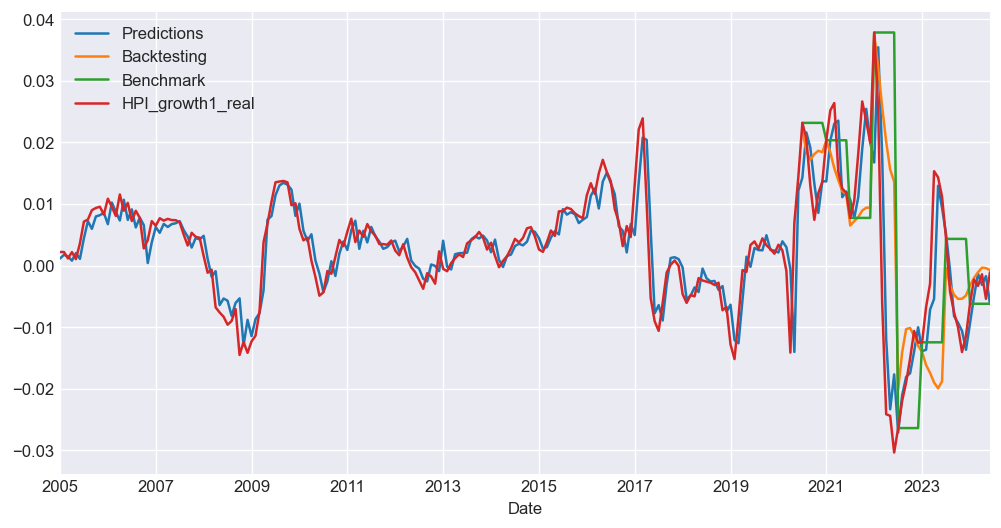

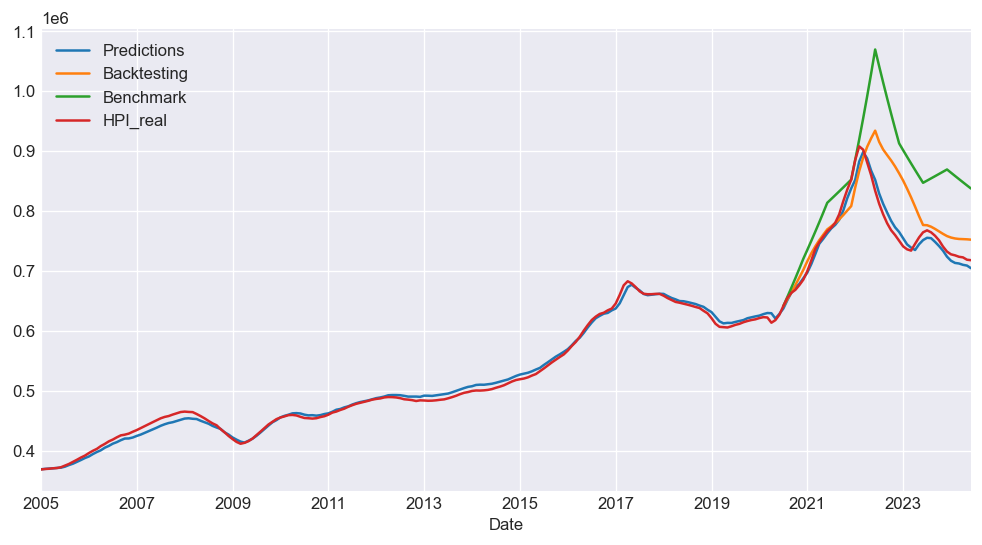

In [38]:
# features = ["M2_growth4_real_lag_2","Mortgage rate 5y_diff1_lag_2","Household saving rate_lag_3"]# 
features = ["Mortgage rate 5y_growth12_lag_6", "M2++_growth1_real_lag_6"]

y_lags = 2
test_split_time = pd.Timestamp("20200625")

features = [target + "_lag_" + str(j) for j in range(y_lags, 0,-1)]  + features

X, y = df_cov[features], df_cov[target]
X_train, y_train = X[:test_split_time], y[:test_split_time]

LR = LinearRegression()
# LR = Lasso(0.000005)
LR.fit(X_train, y_train)
print("coefficients: ", LR.intercept_,  LR.coef_)
preds = LR.predict(X)

forecast = backtesting(df_cov, target, features, test_split_time, 6, y_lags, LR, retrain = True)
forecast2 = backtesting(df_cov, target, features, test_split_time, 6, 1, MA, retrain = True)

series_args = [[forecast, "Backtesting"],
               [forecast2, "Naive "],
               ]

show_results(series_args, y, preds, test_split_time)
show_results(series_args, df["HPI_real"], preds, test_split_time, inverse_transform = True)

sm_est = sm.OLS(y_train, sm.add_constant(X_train))
sm_est2 = sm_est.fit()
print(sm_est2.summary())

## Residual Analysis

(-13.453218266986802, 3.6495251974211057e-25, 0, 233, {'1%': -3.458731141928624, '5%': -2.8740258764297293, '10%': -2.5734243167124093}, -1735.906940164147)


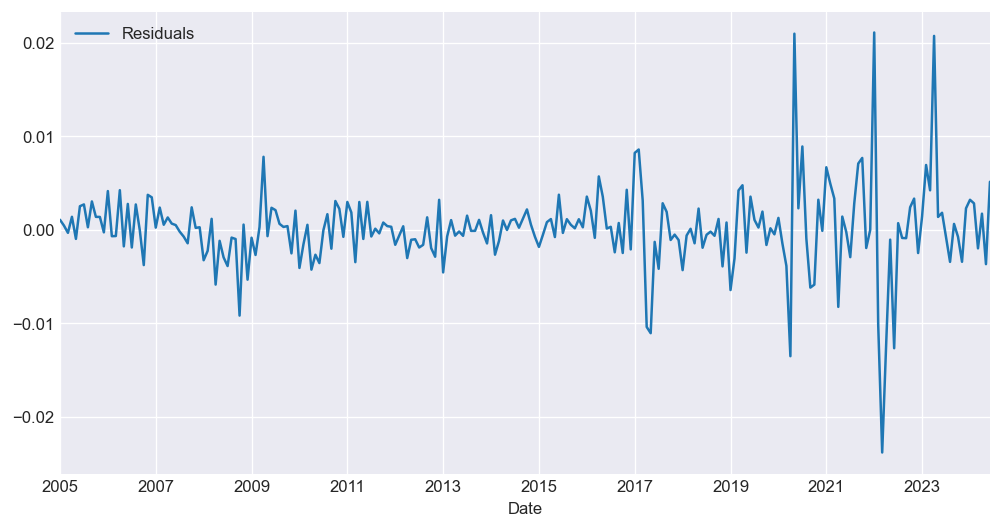

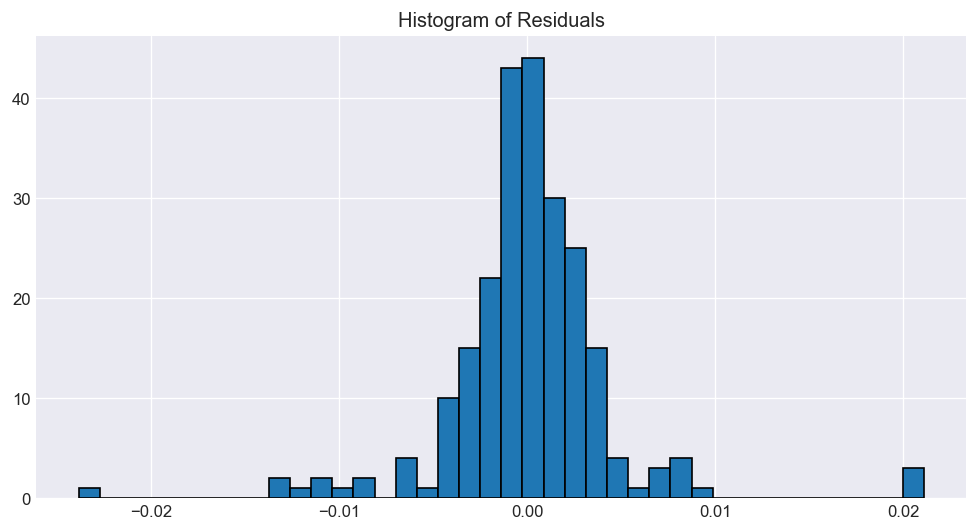

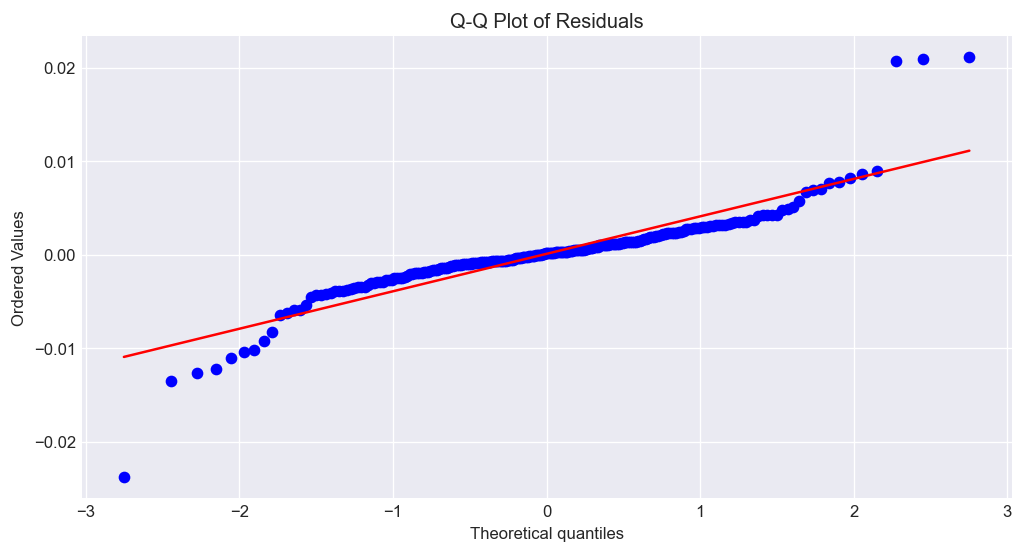

In [33]:
residuals = (df_cov[target].values- preds)
pd.DataFrame(residuals, columns=["Residuals"], index = df_cov.index).plot()

print(adfuller(residuals))
plt.figure()
plt.hist(residuals, bins=40, edgecolor='k')
plt.title('Histogram of Residuals')
plt.show()
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

## Forecast

In [19]:
def predict(df, target, features,  horizon, y_lags, model, retrain=True):
    features_no_lags = [f[:-6] for f in features]
    
    val_df = pd.DataFrame(np.array(df_cov[features_no_lags].iloc[-horizon:]),columns=features, index= pd.date_range(start=df_cov.index[-1], periods=horizon + 1, freq=freq)[1:])

    features =  [target + "_lag_" + str(j) for j in range(y_lags, 0,-1) if target + "_lag_" + str(j) not in features]  + features

    train_y = df[target]
    train_df = df[features]

    if retrain:
        model.fit(train_df,train_y) 
        
    forecast = [train_y.iloc[-i] for i in range(y_lags, 0,-1)]

    for i in range(horizon):
        X = np.array(forecast[-y_lags:] + list(val_df.iloc[i])).reshape(1, -1)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            y_pred = model.predict(X)[0]
        forecast.append(y_pred)

    forecast = pd.Series(forecast[y_lags:], name="Forecast", index = val_df.index)
    return forecast

In [20]:
forecast3 = predict(df_cov, target,  ["Mortgage rate 5y_growth12_lag_6", "M2_growth12_real_lag_6"], 6, 1, LR)

2024-07-01    716863.900807
2024-08-01    716037.326303
2024-09-01    715297.818543
2024-10-01    714666.821631
2024-11-01    714208.188511
2024-12-01    713901.352565
Freq: MS, Name: Forecast, dtype: float64
2024-07-01   -0.001166
2024-08-01   -0.001154
2024-09-01   -0.001033
2024-10-01   -0.000883
2024-11-01   -0.000642
2024-12-01   -0.000430
Freq: MS, Name: Forecast, dtype: float64


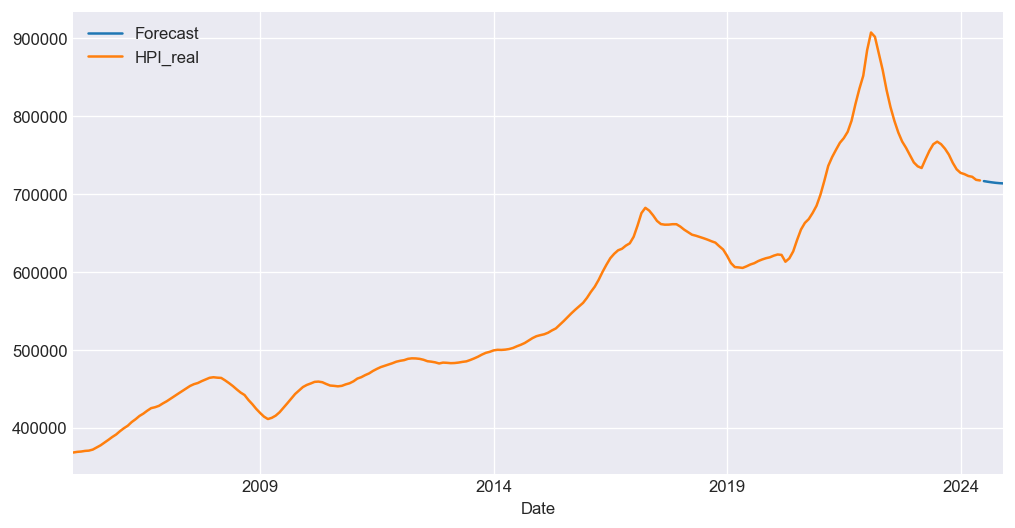

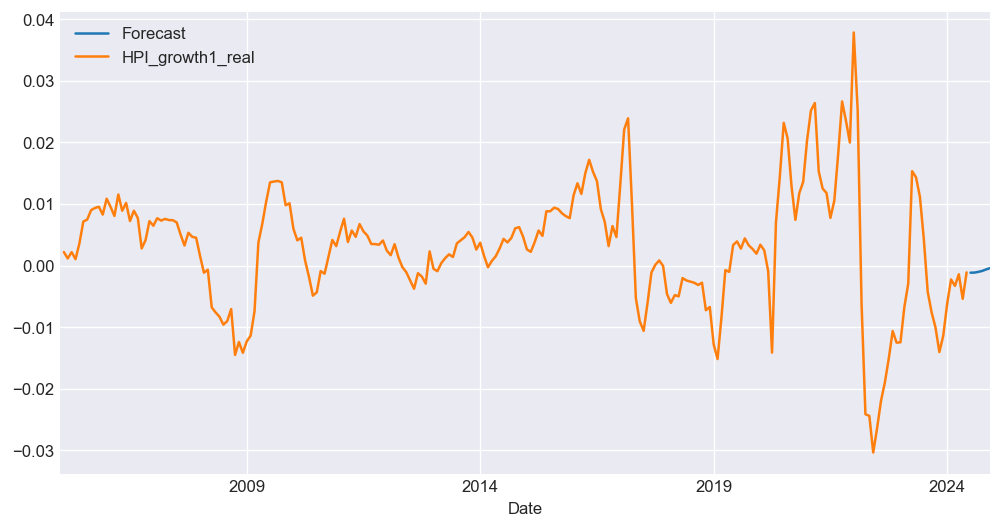

In [21]:
def show_forecast(series, pred, inverse_transform = True):
    if inverse_transform:
        pred = inv_growth(pred, series.iloc[-1])
    figure = plt.figure()
    pred.plot(legend="top")
    series.plot(legend="top")
    print(pred)
show_forecast(df["HPI_real"], forecast3)
show_forecast(df["HPI_growth1_real"], forecast3, False)

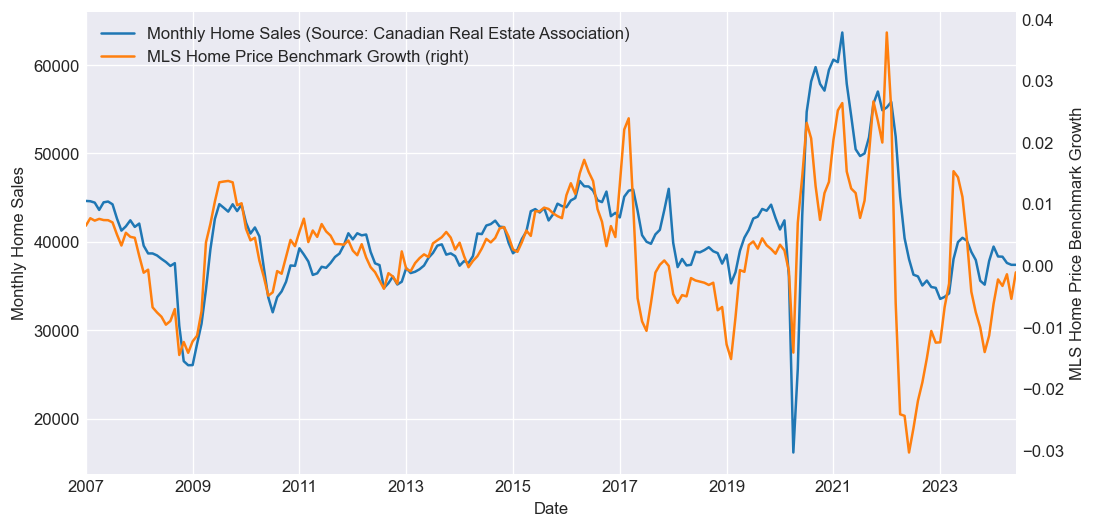

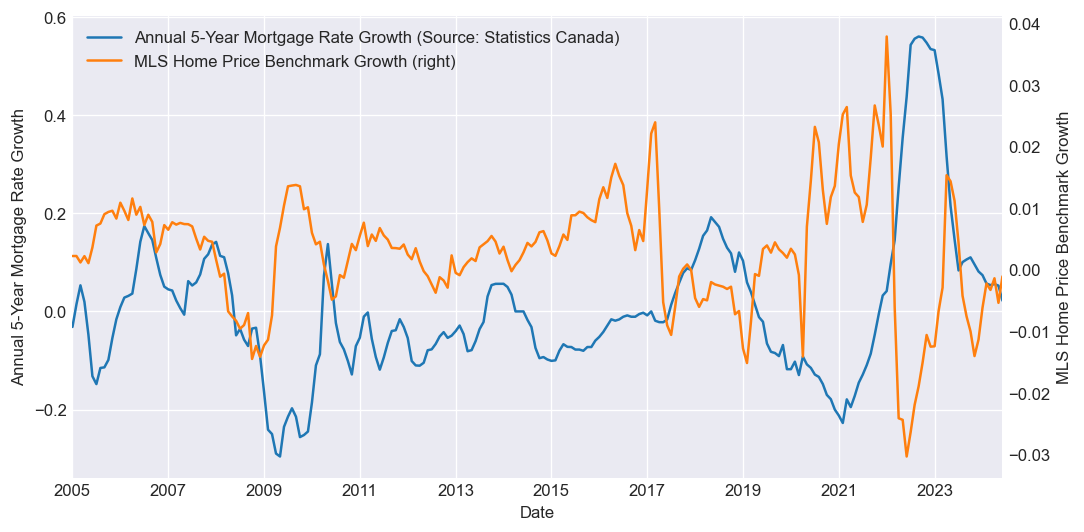

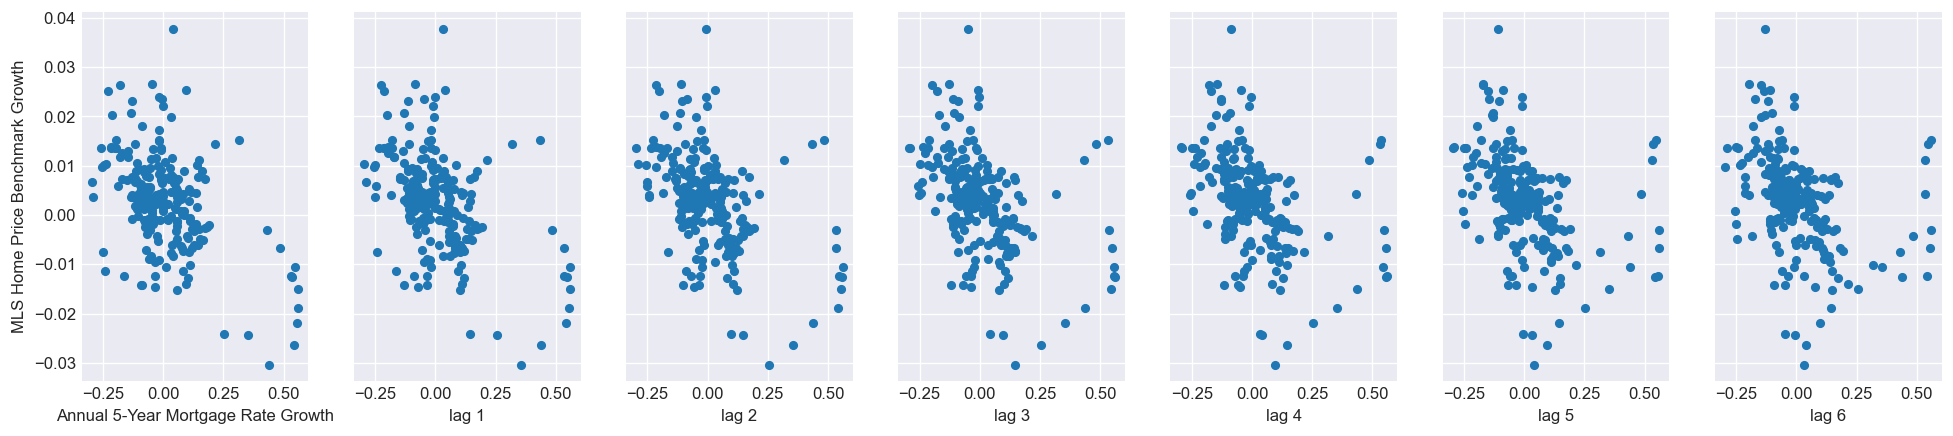

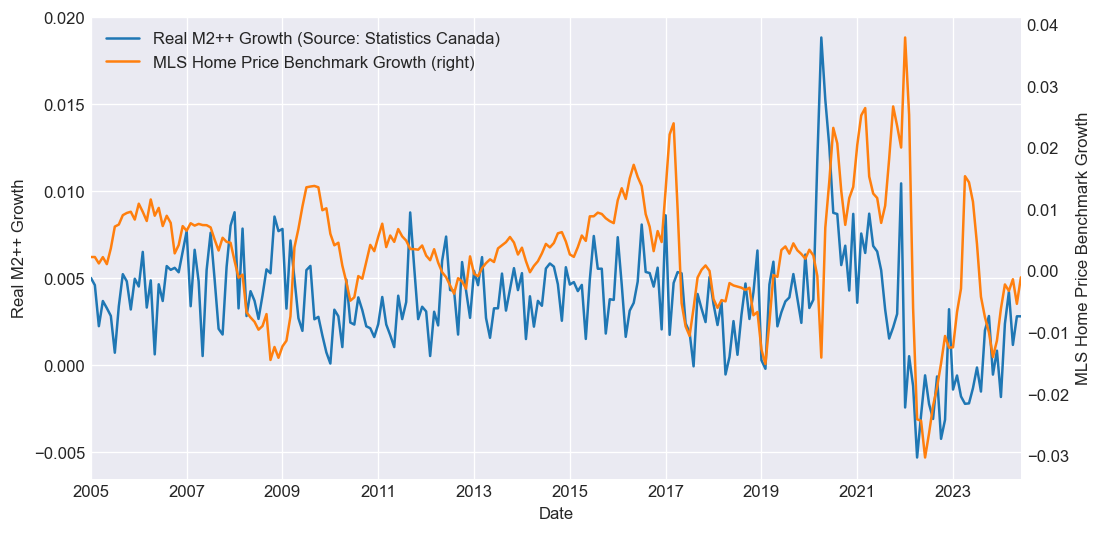

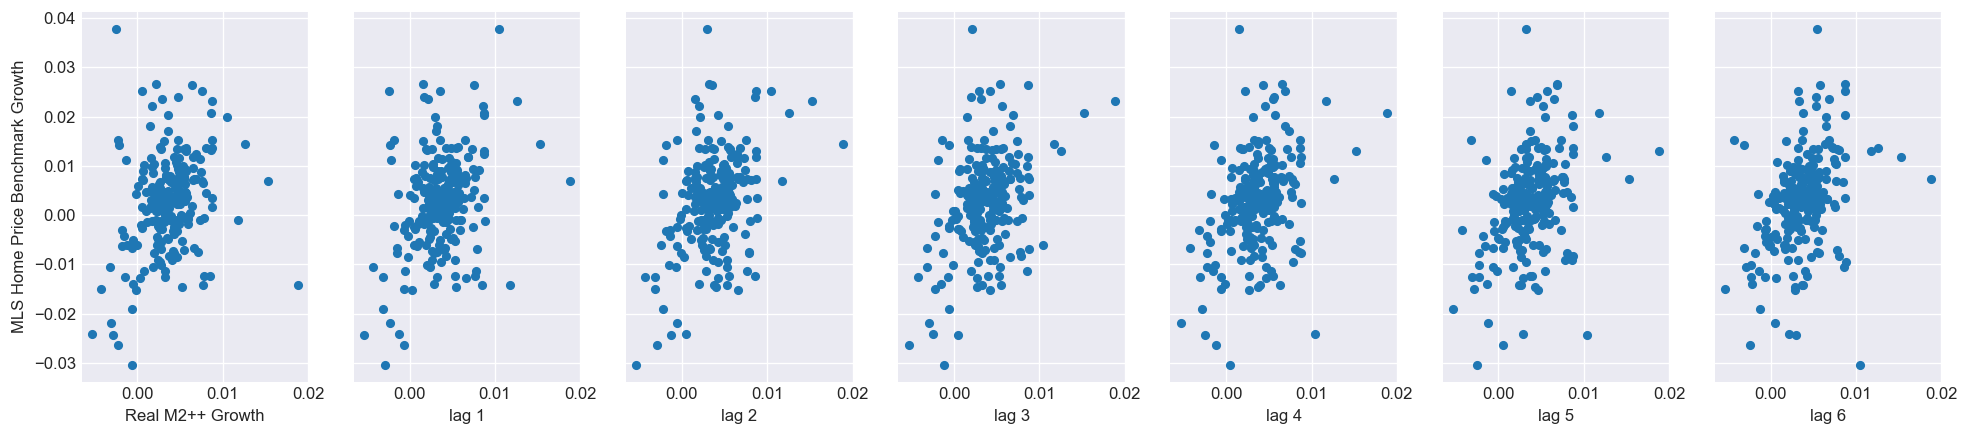

In [10]:
# ["Mortgage rate 5y_growth12_lag_6", "M2++_growth12_real_lag_6"]
fig, ax = plt.subplots()
df_cov["Sales"][pd.Timestamp("20061225"):].plot(label="Monthly Home Sales (Source: Canadian Real Estate Association)", ylabel="Monthly Home Sales", ax=ax, legend="left")
df_cov[target][pd.Timestamp("20061225"):].plot(secondary_y=True, label="MLS Home Price Benchmark Growth", ylabel="MLS Home Price Benchmark Growth", ax=ax, legend="left")


fig, ax = plt.subplots()
df_cov["Mortgage rate 5y_growth12"].plot(label="Annual 5-Year Mortgage Rate Growth (Source: Statistics Canada)", ylabel="Annual 5-Year Mortgage Rate Growth", ax=ax, legend="left")
df_cov[target].plot(secondary_y=True, label="MLS Home Price Benchmark Growth", ylabel="MLS Home Price Benchmark Growth", ax=ax, legend="left")
# ax.set
feature = "Mortgage rate 5y_growth12"
fig, ax = plt.subplots(1, 7, sharey="row", figsize=(20,4))
for j in range(7):
    col_name  = feature if j==0 else feature + "_lag_" + str(j)
    if col_name in df_cov.columns:
        df_cov.plot.scatter(col_name, target, ax=ax[j])
        ax[j].set_xlabel("Annual 5-Year Mortgage Rate Growth" if j==0 else "lag " + str(j))
        ax[j].set_ylabel("MLS Home Price Benchmark Growth")

fig, ax = plt.subplots()
df_cov["M2++_growth1_real"].plot(label="Real M2++ Growth (Source: Statistics Canada)", ylabel="Real M2++ Growth", ax=ax, legend="left")
df_cov[target].plot(secondary_y=True, label="MLS Home Price Benchmark Growth", ylabel="MLS Home Price Benchmark Growth", ax=ax, legend="left")
# ax.set
feature = "M2++_growth1_real"
fig, ax = plt.subplots(1, 7, sharey="row", figsize=(20,4))
for j in range(7):
    col_name  = feature if j==0 else feature + "_lag_" + str(j)
    if col_name in df_cov.columns:
        df_cov.plot.scatter(col_name, target, ax=ax[j])
        ax[j].set_xlabel("Real M2++ Growth" if j==0 else "lag " + str(j))
        ax[j].set_ylabel("MLS Home Price Benchmark Growth")